## ✅ **Анализ донорства крови. Синьчжу, Тайвань**

Цели и задачи:

Набор данных содержит информацию о донорах и выполненных ими трансфузиях до марта 2007 года включительно.

Целью данного исследования является построение методами машинного обучения прогноза сдачи донором крови в марте 2007 года. Полученный результат позволяет оценить вероятность посещения донором центра сдачи крови в дальнейшем и относится к задачам бинарной классификации.

В исследовании используется база данных доноров медицинского центра города Синьчжу на Тайване.

Описание набора данных:

Из базы данных медицинского центра случайным образом были выбраны **748** доноров для анализа. Информация находится в файле "*blood.csv*" в виде таблицы Excel с разделителями формата.

Выборка по каждому из доноров содержит следующие признаки:

- *Recency*   - количество месяцев с момента последней сдачи крови донором;
- *Frequency* - общее количество трансфузий донора;
- *Monetary*  - количество сданной донором крови в куб. см.;
- *Time*      - количество месяцев с момента первого донорства;
- *Class*     - целевая переменная прогноза трансфузии.

## ✅ **Исследовательский анализ данных (EDA)**

Устанавливаем стандартные библиотеки:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Отключаем предупреждения:

In [ ]:
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

Загружаем набор данных их хранилища и сохраняем его:

In [ ]:
url = "https://raw.githubusercontent.com/pycaret/datasets/main/data/common/blood.csv"
blood = pd.read_csv(url)
blood.to_csv('blood.csv')
from google.colab import files
files.download('blood.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Проанализируем загруженные данные:

In [ ]:
print(blood.shape)
blood.sample(5)

(748, 5)


,Recency,Frequency,Monetary,Time,Class
726,25,6,1500,50,0
594,5,11,2750,75,0
371,14,3,750,31,0
10,4,23,5750,58,0
715,16,5,1250,71,0


Размерность таблицы данных составляет **5** признаков при **748** выборках.

Создадим таблицу, описывающую наши данные:

In [ ]:
data = pd.DataFrame(blood.dtypes)
data = data.rename(columns={0:'Тип данных'})
data['Количество'] = blood.count()
data['Уникальных Значений'] = blood.nunique()
data['Пропущенных Значений'] = blood.isnull().sum()
print(data)

          Тип данных  Количество  Уникальных Значений  Пропущенных Значений
Recency        int64         748                   31                     0
Frequency      int64         748                   33                     0
Monetary       int64         748                   33                     0
Time           int64         748                   78                     0
Class          int64         748                    2                     0


Набор данных состоит только из числовых признаков *int64*, пропущенных значений нет.

In [ ]:
blood['Class'].value_counts()

0    570
1    178
Name: Class, dtype: int64

Целевая переменная **Class** является категориальной, со значениям '0' и '1'.

<Axes: xlabel='Class', ylabel='count'>

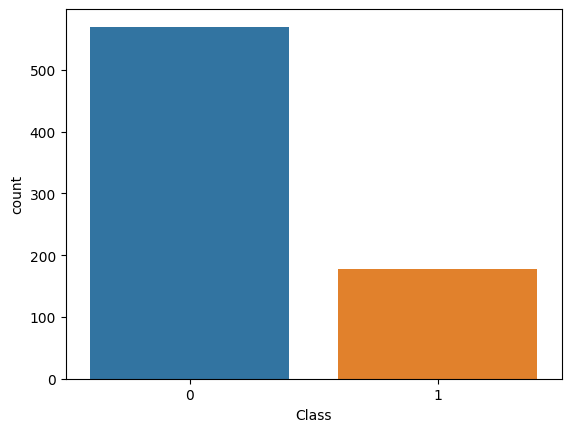

In [ ]:
sns.countplot(blood, x='Class')

Набор данных имеет небольшой дисбаланс, класс со значением '**0**' является доминирующим в соотношении 3.2/1.

In [ ]:
blood.describe()

,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


Наблюдается большой разрыв между 50%-квантилем и средним значением по параметру *Monetary*, а также между 75%-квантилем и максимальными значениями всех параметров, что указывает на наличие выбросов.

Проанализируем исходные признаки:

<Axes: xlabel='Time', ylabel='Count'>

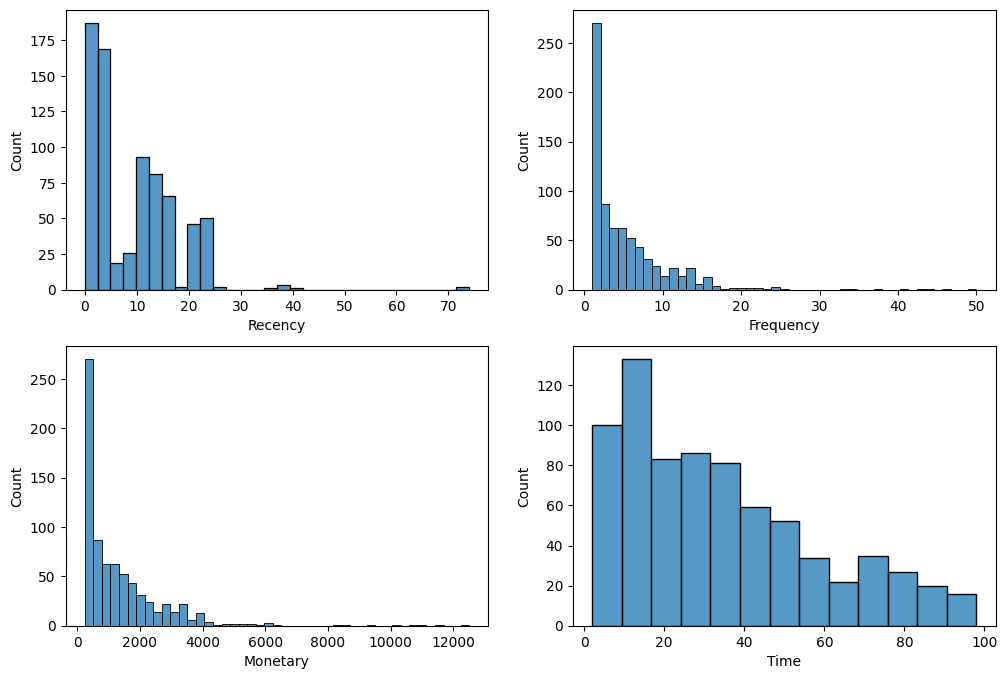

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(x=blood['Recency'],ax=ax[0,0])
sns.histplot(x=blood['Frequency'],ax=ax[0,1])
sns.histplot(x=blood['Monetary'],ax=ax[1,0])
sns.histplot(x=blood['Time'],ax=ax[1,1])

<Axes: >

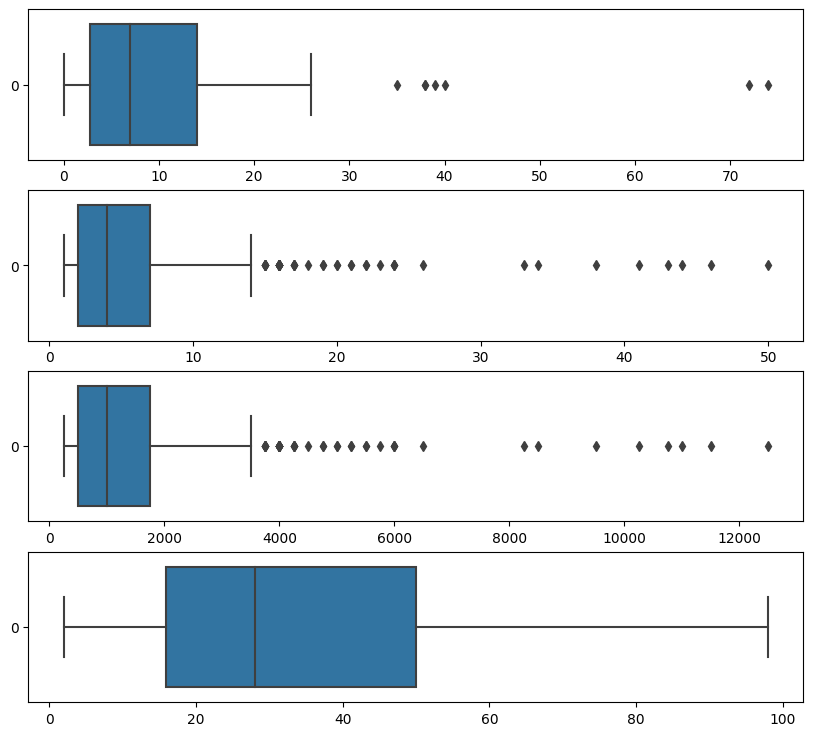

In [ ]:
fig, ax = plt.subplots(4, figsize=(10, 9))
sns.boxplot(blood['Recency'], orient='h', ax=ax[0])
sns.boxplot(blood['Frequency'], orient='h', ax=ax[1])
sns.boxplot(blood['Monetary'], orient='h', ax=ax[2])
sns.boxplot(blood['Time'], orient='h', ax=ax[3])

По столбцу **Time** - выбросов не наблюдаем.

Удаляем выбросы по остальным признакам:

In [ ]:
before = blood.shape[0]
print('Количество записей до удаления выбросов:', before)
blood = blood.loc[blood['Recency'] < 30]
blood = blood.loc[blood['Frequency'] < 30]
blood = blood.loc[blood['Monetary'] < 8000]
blood.reset_index(inplace=True, drop=True)
after = blood.shape[0]
print('Количество записей после удаления выбросов:', after)
print('Удалено записей, %: {0:0.2f}'.format((1-after/before)*100))

Количество записей до удаления выбросов: 748
Количество записей после удаления выбросов: 733
Удалено записей, %: 2.01


Оценим отношения между различными признаками в наборе данных:

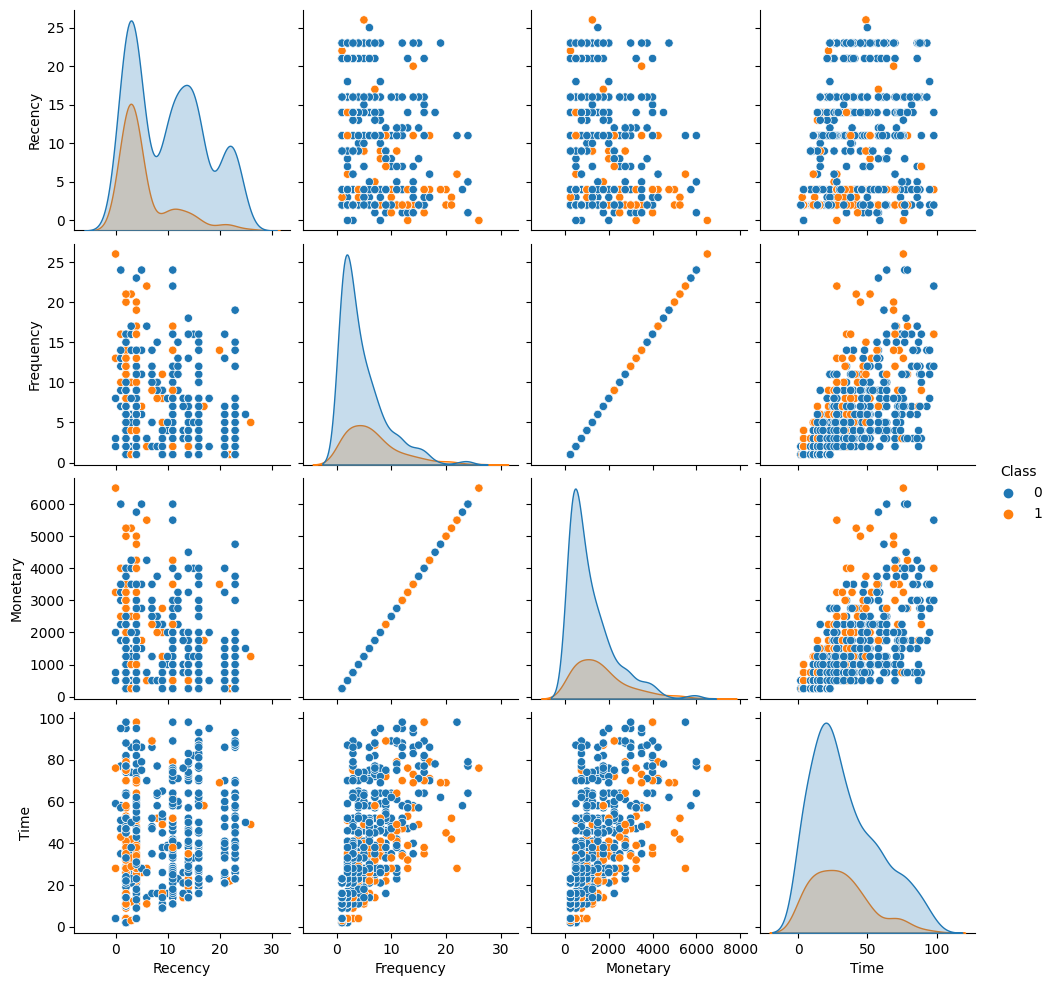

In [ ]:
sns.pairplot(blood, kind='scatter', diag_kind='kde', hue='Class')

Матрица корреляции:

<Axes: >

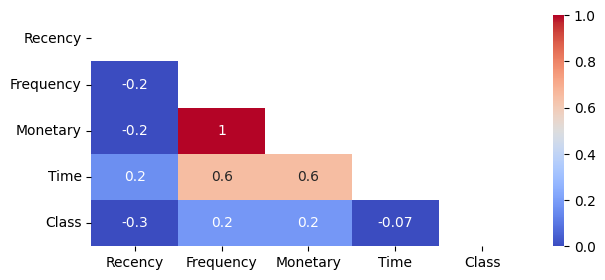

In [ ]:
plt.figure(figsize = (7,3))
sns.heatmap(blood.corr(), annot=True, fmt='.1g', vmin=0, vmax=1, cmap='coolwarm', mask=np.triu(blood.corr()))

Целевая переменная *Class* имеет слабую корреляцию с признаками *Recency*, *Frequency*, *Monetary* и практически отсутствующую - с *Time*.

Наблюдаем сильную прямую зависимость между признаками *Frequency* - *Time*, *Monetary* - *Time*.

Мы видим, что параметры *Frequency* и *Monetary* имеют **идеальную положительную корреляцию** - это связано с тем, что в нашем примере у каждого донора во время трансфузии забирают строго определенный объём крови равный 250 куб. см. Соответственно, мы можем удалить один из таких признаков, например '*Monetary*' - как имеющий наибольший разброс значений:

In [ ]:
blood.head(3)

,Recency,Frequency,Monetary,Time,Class
0,0,13,3250,28,1
1,1,16,4000,35,1
2,2,20,5000,45,1


In [ ]:
blood.drop('Monetary', axis=1, inplace=True)
blood.head(3)

,Recency,Frequency,Time,Class
0,0,13,28,1
1,1,16,35,1
2,2,20,45,1


## ✅ **Библиотеки машинного обучения**

###1️⃣ **Scikit-Learn**

### **Предварительная обработка данных** (Data Preprocessing)

Создадим обучающие и тренировочные наборы данных с удалением столбца целевого признака:

In [ ]:
X = blood.drop(['Class'], axis=1)
y = blood['Class']
print(X.shape, y.shape)
X.sample(3)

(733, 3) (733,)


,Recency,Frequency,Time
567,2,1,2
120,2,6,41
224,4,1,4


Используем метод **SMOTE** (*Synthetic Minority Over-sampling Technique*) для предварительной обработки данных.

Метод *SMOTE* используется для увеличения числа экземпляров миноритарного класса и устраняет дисбаланс классов в наборе данных:

In [ ]:
from imblearn.over_sampling import SMOTE

print('Количество записей до обработки SMOTE:')
print(X.shape, y.shape)
X, y = SMOTE().fit_resample(X, y)
print('Количество записей после обработки SMOTE:')
print(X.shape, y.shape)

Количество записей до обработки SMOTE:
(733, 3) (733,)
Количество записей после обработки SMOTE:
(1122, 3) (1122,)


Теперь набор данных сбалансирован:

In [ ]:
print('Всего выборок:', y.count())
print(y.value_counts())
X.sample(3)

Всего выборок: 1122
1    561
0    561
Name: Class, dtype: int64


,Recency,Frequency,Time
403,16,1,16
321,14,8,50
893,4,7,59


Разделяем данные на *обучающий* и *тестовый* наборы:


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=123434)

print('Количество записей после разделения данных:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Количество записей после разделения данных:
(785, 3) (337, 3) (785,) (337,)


Основными качественными характеристиками задачи бинарной классификации являются метрики *F1-score*, *Precision*, *Recall*, *Accuracy* и *AUC* (Area Under Curve).

Создадим список таких метрик для итоговой оценки всех моделей в конце текущего задания:

In [ ]:
score_results = []

### **Cлучайный лес** (Scikit-Learn Random Forest)

Загружаем модель из библиотеки и выводим её параметры, используемые по умолчанию:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_sklearn = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_sklearn.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

Зададим диапазоны гиперпараметров и вычислим их оптимальные значения для модели, используя метод **RandomizedSearchCV**:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [5, 30, 50, 100, 200, 300]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num=12)]
min_samples_split = [2, 3, 4, 6, 10]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_random = RandomForestClassifier(n_estimators=100, random_state=1234)

rf_random = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=random_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=1234,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)
print('Оптимальные параметры модели:')
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Оптимальные параметры модели:


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

Используем вычисленные значения оптимальных параметров в нашей основной модели и выведем отчет классификации для оценки качества прогнозирования:

In [ ]:
from sklearn.metrics import classification_report

rf_sklearn = RandomForestClassifier(
    n_estimators=rf_random.best_params_.get('n_estimators'),
    min_samples_split=rf_random.best_params_.get('min_samples_split'),
    min_samples_leaf=rf_random.best_params_.get('min_samples_leaf'),
    max_features=rf_random.best_params_.get('max_features'),
    max_depth=rf_random.best_params_.get('max_depth'),
    bootstrap=rf_random.best_params_.get('bootstrap')
)

rf_sklearn.fit(X_train, y_train)
y_pred = rf_sklearn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       168
           1       0.75      0.71      0.73       169

    accuracy                           0.73       337
   macro avg       0.73      0.73      0.73       337
weighted avg       0.73      0.73      0.73       337



Матрица ошибок:

(Text(0.5, 1.0, 'Случайный лес \n Scikit-Learn'),
 Text(0.5, 0, 'Прогноз'),
 Text(0, 0.5, 'Факт'))

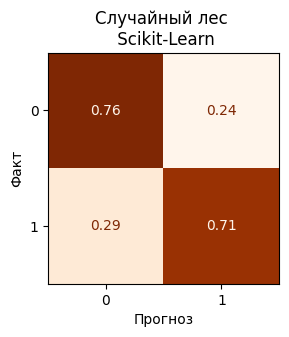

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_sklearn, X_test, y_test, ax=ax, cmap='Oranges', colorbar=False, normalize='true')
ax.set_title('Случайный лес \n Scikit-Learn'), ax.set_xlabel('Прогноз'), ax.set_ylabel('Факт')

Итоговые оценки модели:

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

f1   = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_pred)

print('F1-score  : {0:0.4f}'.format(f1))
print('Precision : {0:0.4f}'.format(prec))
print('Recall    : {0:0.4f}'.format(rec))
print('Accuracy  : {0:0.4f}'.format(acc))
print('AUC       : {0:0.4f}'.format(auc))

F1-score  : 0.7273
Precision : 0.7453
Recall    : 0.7101
Accuracy  : 0.7329
AUC       : 0.7330


Добавляем метрики модели в итоговую таблицу результатов:

In [ ]:
score_results.append(('Scikit-Learn', 'RandomForestClassifier', f1, prec, rec, acc, auc, rf_sklearn))

### **Градиентный бустинг** (Scikit-Learn Gradient Boosting)

Загружаем модель из библиотеки и выводим её параметры, используемые по умолчанию:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_sklearn = GradientBoostingClassifier(n_estimators=100, random_state=1234)
gb_sklearn.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Зададим диапазоны гиперпараметров и вычислим их оптимальные значения для модели, используя функцию **RandomizedSearchCV**:

In [ ]:
n_estimators=[5, 30, 50, 100, 200, 300]
max_features=['log2', 'sqrt']
max_depth=[int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split=[2, 3, 4, 6, 10]
learning_rate=[0.1, 0.2, 0.3, 0.5]
subsample=[0.1, 0.2, 0.3, 0.5]
min_samples_leaf = [1, 2, 3, 4, 5, 10]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'learning_rate': learning_rate,
    'subsample': subsample,
    'min_samples_leaf': min_samples_leaf
}

gb_random = GradientBoostingClassifier(n_estimators=100, random_state=1234)

gb_random = RandomizedSearchCV(
    estimator=gb_random,
    param_distributions = random_grid,
    n_iter=100,
    cv = 5,
    verbose=2,
    random_state=1234,
    n_jobs = -1
)

gb_random.fit(X_train, y_train)
print('Оптимальные параметры модели:')
gb_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Оптимальные параметры модели:


{'subsample': 0.5,
 'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 30,
 'learning_rate': 0.1}

Используем вычисленные значения оптимальных параметров в нашей основной модели и выведем отчет классификации для оценки качества прогнозирования:

In [ ]:
gb_sklearn = GradientBoostingClassifier(
    n_estimators=gb_random.best_params_.get('n_estimators'),
    min_samples_split=gb_random.best_params_.get('min_samples_split'),
    min_samples_leaf=gb_random.best_params_.get('min_samples_leaf'),
    max_features=gb_random.best_params_.get('max_features'),
    max_depth=gb_random.best_params_.get('max_depth'),
    subsample=gb_random.best_params_.get('subsample'),
    learning_rate=gb_random.best_params_.get('learning_rate')
)

gb_sklearn.fit(X_train, y_train)
y_pred = gb_sklearn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       168
           1       0.75      0.72      0.74       169

    accuracy                           0.74       337
   macro avg       0.74      0.74      0.74       337
weighted avg       0.74      0.74      0.74       337



Матрица ошибок:

(Text(0.5, 1.0, 'Градиентный бустинг \n Scikit-Learn'),
 Text(0.5, 0, 'Прогноз'),
 Text(0, 0.5, 'Факт'))

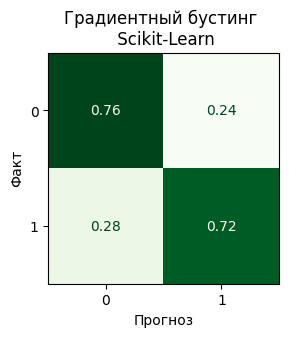

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(gb_sklearn, X_test, y_test, ax=ax, cmap='Greens', colorbar=False, normalize='true')
ax.set_title('Градиентный бустинг \n Scikit-Learn'), ax.set_xlabel('Прогноз'), ax.set_ylabel('Факт')

Итоговые оценки модели:

In [ ]:
f1   = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_pred)

print('F1-score  : {0:0.4f}'.format(f1))
print('Precision : {0:0.4f}'.format(prec))
print('Recall    : {0:0.4f}'.format(rec))
print('Accuracy  : {0:0.4f}'.format(acc))
print('AUC       : {0:0.4f}'.format(auc))

F1-score  : 0.7372
Precision : 0.7531
Recall    : 0.7219
Accuracy  : 0.7418
AUC       : 0.7419


Добавляем метрики модели в итоговую таблицу результатов:

In [ ]:
score_results.append(('Scikit-Learn', 'GradientBoostingClassifier', f1, prec, rec, acc, auc, gb_sklearn))

Сравнение матриц ошибок моделей:

(Text(0.5, 1.0, 'Градиентный бустинг'),
 Text(0.5, 0, 'Прогноз'),
 Text(0, 0.5, 'Факт'))

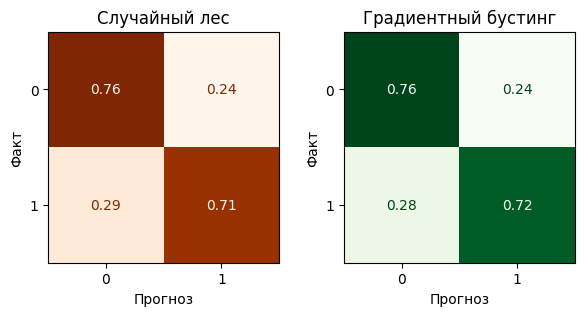

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))

ConfusionMatrixDisplay.from_estimator(rf_sklearn, X_test, y_test, ax=ax[0], cmap='Oranges', colorbar=False, normalize='true')
ax[0].set_title('Случайный лес'), ax[0].set_xlabel('Прогноз'), ax[0].set_ylabel('Факт')
ConfusionMatrixDisplay.from_estimator(gb_sklearn, X_test, y_test, ax=ax[1], cmap='Greens', colorbar=False, normalize='true')
ax[1].set_title('Градиентный бустинг'), ax[1].set_xlabel('Прогноз'), ax[1].set_ylabel('Факт')

### 2️⃣ **AutoGluon**

Устанавливаем библиотеку **AutoGluon**:

In [ ]:
!pip install autogluon
!pip install autogluon.eda

      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 60.2.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.28.2 which is incompatible.
tensorflow 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184108 sha256=9b2bf5c1aa176c75a1749f7e6a6b37e2530547e0f13d09ec52624330bbbe9378
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
  Created wheel for suod: filename=suod-0.0.9-py3-none-any.wh

### **Предварительная обработка данных** (Data Preprocessing)

В **AutoGluon** для обработки стандартных типов данных таких как таблицы, базы данных и.т.д., которые не содержат графики или неструктурированного текста - используется собственный класс **TabularDataset**.

Загружаем исходный набор данных:

In [ ]:
from autogluon.tabular import TabularDataset

blood = TabularDataset('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/blood.csv')
blood.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


Используем метод **SMOTE** (*Synthetic Minority Over-sampling Technique*) для предварительной обработки данных.

Метод *SMOTE* используется для увеличения числа экземпляров миноритарного класса и устраняет дисбаланс классов в наборе данных:

In [ ]:
from imblearn.over_sampling import SMOTE

print('Количество записей в наборе blood до обработки SMOTE:')
print(blood.shape)
X_blood, y_blood = SMOTE().fit_resample(blood.iloc[:,:-1], blood['Class'])
print('Количество записей X_blood и y_blood после обработки SMOTE:')
print(X_blood.shape, y_blood.shape)
print('X_blood:')
print(X_blood)
print('Столбец целевой переменной y_blood:')
print(y_blood)

Количество записей в наборе blood до обработки SMOTE:
(748, 5)
Количество записей X_blood и y_blood после обработки SMOTE:
(1140, 4) (1140,)
X_blood:
[[    2    50 12500    98]
 [    0    13  3250    28]
 [    1    16  4000    35]
 ...
 [    2    20  5069    44]
 [    4     5  1250    24]
 [    2    16  4131    53]]
Столбец целевой переменной y_blood:
0       1
1       1
2       1
3       1
4       0
       ..
1135    1
1136    1
1137    1
1138    1
1139    1
Name: Class, Length: 1140, dtype: int64


Поскольку библиотека AutoGluon использует данные для обучения в своих датафреймах *TabularDataset* без удаления целевого столбца, необходимо объединить обратно в одну таблицу тренировочные данные **X_blood** и столбец целевой переменной **y_blood** после обработки SMOTE. Также восстановим начальные заголовки столбцов:

In [ ]:
X_blood = pd.DataFrame(X_blood)
blood_after_SMOTE = pd.concat([X_blood, y_blood], sort=False, axis=1)
blood_after_SMOTE.rename(columns={0:'Recency', 1:'Frequency', 2:'Monetary', 3:'Time', 4:'Recall'}, inplace=True)
print(blood_after_SMOTE.shape)
blood_after_SMOTE.head()

(1140, 5)


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


Устанавливаем целевую переменную:

In [ ]:
label='Class'

Разделим наш обработанный набор данных на две выборки - **train** и **test** в соотношении 70/30:

In [ ]:
print('Начальный набор данных:')
print(blood_after_SMOTE.shape)

train, test = train_test_split(blood_after_SMOTE, test_size=0.3, random_state=1234)

print('Количество записей после разделения данных:')
print(train.shape, test.shape)

Начальный набор данных:
(1140, 5)
Количество записей после разделения данных:
(798, 5) (342, 5)


### **Автоматический анализ набора данных** (Automated Dataset Overview):

В **AutoGluon** имеется метод *dataset_overview* для проведения автоматического анализа загруженного набора данных:

**`train_data` dataset summary**

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,variable_type,special_types
Class,798,0.510025,0.500213,0.0,0.0,1.0,1.00,1.0,int64,2,,,int,category,
Frequency,798,5.983709,6.203653,1.0,2.0,5.0,7.00,50.0,int64,35,,,int,numeric,
Monetary,798,1499.588972,1560.548461,250.0,500.0,1250.0,1750.00,12500.0,int64,52,,,int,numeric,
Recency,798,7.847118,7.094040,0.0,2.0,4.0,12.75,72.0,int64,26,,,int,numeric,
Time,798,32.557644,23.250230,2.0,14.0,28.0,47.00,98.0,int64,89,,,int,numeric,


**`test_data` dataset summary**

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,variable_type,special_types
Class,342,0.476608,0.500184,0.0,0.0,0.0,1.0,1.0,int64,2,,,int,category,
Frequency,342,6.587719,7.080780,1.0,2.0,5.0,8.0,46.0,int64,29,,,int,numeric,
Monetary,342,1653.210526,1786.339712,250.0,500.0,1250.0,2000.0,11744.0,int64,39,,,int,numeric,
Recency,342,8.181287,7.937210,0.0,2.0,4.0,14.0,74.0,int64,29,,,int,numeric,
Time,342,34.330409,23.550013,2.0,16.0,29.0,46.0,98.0,int64,75,,,int,numeric,


### Feature Distance

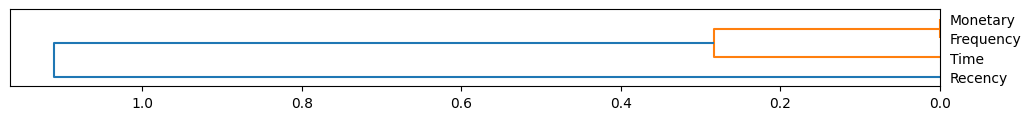

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `Frequency`, `Monetary` - distance `0.00`

Feature interaction between `Frequency`/`Monetary`

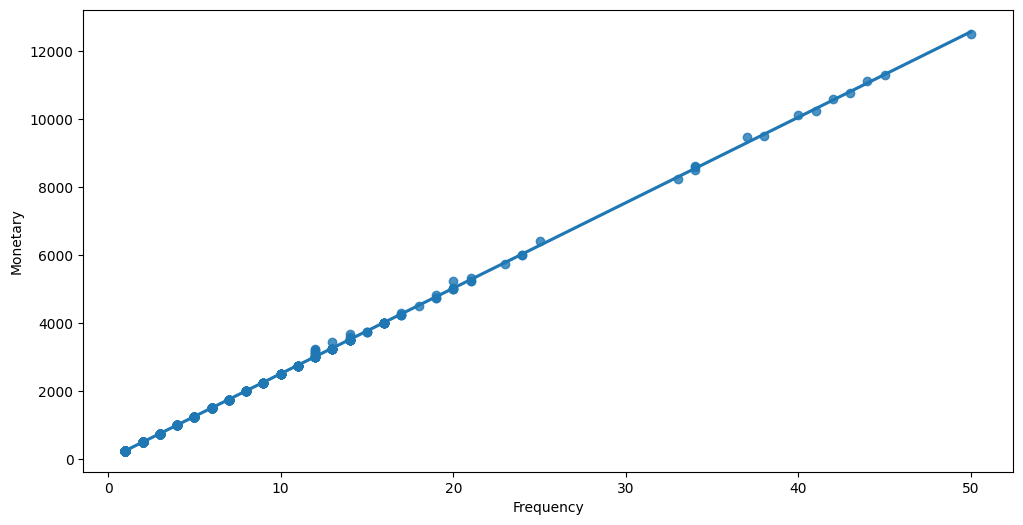

In [ ]:
import autogluon.eda.auto as auto

ADO = auto.dataset_overview(train_data=train, test_data=test, label=label)

По результатам анализа обнаружены дублирующие друг друга признаки *Frequency* и *Monetary*.

### **Автоматический анализ целевой переменной** (Automated Target Variable Analysis):

В **AutoGluon** имеется возможность проведения автоматического анализа целевой переменной с помощью функции *target_analysis*:

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
Class,798,0.510025,0.500213,0.0,0.0,1.0,1.0,1.0,int64,2,,,int,


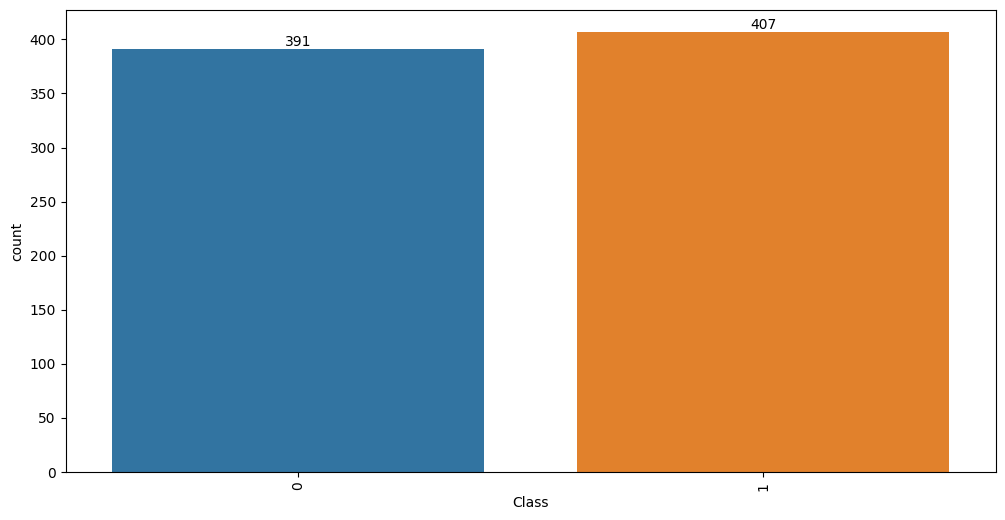

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `Class`.

In [ ]:
ATVA = auto.target_analysis(train_data=train, label=label)

В результате анализа дисбаланса данных не обнаружено.

Корреляция > 0.5 между какими-либо признаками из набора данных также не обнаружена.

### **Автоматическая ускоренная оценка модели** (Automated Quick Model Fit)

Воспользуемся методом ускоренной оценки и получим предварительный прогноз по модели на обучающих данных:

No path specified. Models will be saved in: "AutogluonModels/ag-20230915_132909/"


### Model Prediction for Class

Using validation data for `Test` points

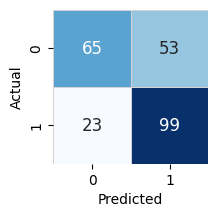

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.683333,0.678571,0.001742,0.010058,0.527972,0.001742,0.010058,0.527972,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
Recency,0.180833,0.054215,0.000863,5,0.292462,0.069204
Time,0.002500,0.014907,0.363348,5,0.033194,-0.028194
Monetary,0.000000,0.000000,0.500000,5,0.000000,0.000000
Frequency,-0.005000,0.001863,0.998059,5,-0.001163,-0.008837


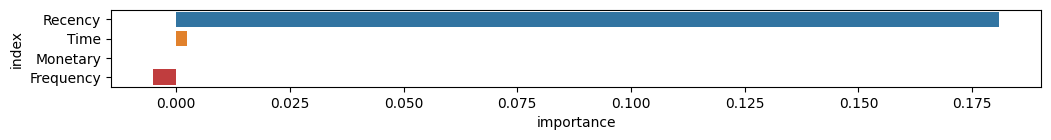

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,Recency,Frequency,Monetary,Time,Class,0,1,error
105,6,17,4250,70,0,0.456286,0.543714,0.087428
30,1,14,3500,58,0,0.456286,0.543714,0.087428
513,3,14,3500,35,0,0.456286,0.543714,0.087428
10,4,23,5750,58,0,0.456286,0.543714,0.087428
546,7,14,3500,48,0,0.456286,0.543714,0.087428
131,2,12,3000,95,0,0.456286,0.543714,0.087428
527,2,15,3750,64,0,0.456286,0.543714,0.087428
46,2,9,2250,36,0,0.463978,0.536022,0.072044
605,4,11,2750,95,0,0.463978,0.536022,0.072044
532,4,8,2000,28,0,0.463978,0.536022,0.072044


### Rows with the least distance vs other class

Rows in this category are the closest to the decision boundary vs the other class and are good candidates for additional labeling

,Recency,Frequency,Monetary,Time,Class,0,1,error
358,9,2,500,26,0,0.496524,0.503476,0.006953
430,9,2,500,52,0,0.496524,0.503476,0.006953
995,10,14,3500,62,1,0.506053,0.493947,0.012106
708,11,2,500,38,1,0.506053,0.493947,0.012106
1090,11,4,1000,16,1,0.506053,0.493947,0.012106
950,13,3,750,16,1,0.506053,0.493947,0.012106
843,10,9,2250,68,1,0.506053,0.493947,0.012106
751,11,8,2000,41,1,0.506053,0.493947,0.012106
761,10,17,4293,78,1,0.506053,0.493947,0.012106
882,11,2,500,36,1,0.506053,0.493947,0.012106


In [ ]:
AQMF = auto.quick_fit(train_data=train, label='Class', return_state=True, show_feature_importance_barplots=True)

По результатам оценки библиотека рекомендует вариант выбора наилучшей модели, а также показывает ряды данных - на которые следует обратить внимание и проанализировать дополнительно - из-за ошибок при прогнозировании выбора целевой переменной.

Удаляем *Monetary* как дублирующий *Frequency* признак и имеющий наименьшую важность:

In [ ]:
train.drop('Monetary', axis=1, inplace=True)
test.drop('Monetary', axis=1, inplace=True)
train.sample(3)

,Recency,Frequency,Time,Class
786,3,6,16,1
700,16,3,35,0
408,16,1,16,0


### **Создание и обучение предиктора** (TabularPredictor)

Библиотека **AutoGluon** в автоматическом режиме:
- распознаёт задачу классификации
- настраивает гиперпараметры
- обучает модели
- собирает ансамбль моделей для создания предиктора класса **TabularPredictor**.

Проведём тренировку нашей модели на обучающих данных с оптимизацией по метрике **F1-score**:

In [ ]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(label=label, eval_metric='f1'
                            ).fit(train_data=train,
                                  calibrate_decision_threshold=True,
                                  verbosity=1,)

No path specified. Models will be saved in: "AutogluonModels/ag-20230915_132911/"
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])


Библиотека AutoGluon автоматически определила задачу как бинарную классификацию.

Результаты обучения модели, отсортированные по ранее заданной метрике **eval_metric='f1'** предиктора:

In [ ]:
predictor.fit_summary(verbosity=1, show_plot=False)

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            XGBoost_BAG_L1   0.778429       0.069208  39.251217                0.069208          39.251217            1       True         11
1       WeightedEnsemble_L2   0.778429       0.075330  45.056912                0.006122           5.805695            2       True         14
2           LightGBM_BAG_L1   0.775558       0.025279  30.599244                0.025279          30.599244            1       True          4
3    NeuralNetFastAI_BAG_L1   0.766864       0.379093  46.771235                0.379093          46.771235            1       True         10
4           CatBoost_BAG_L1   0.766311       0.013140  22.202136                0.013140          22.202136            1       True          7
5      LightGBMLarge_BAG_L1   0.764120       0.027142  30.861155                

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.7048780487804879,
  'KNeighborsDist_BAG_L1': 0.7173913043478262,
  'LightGBMXT_BAG_L1': 0.7640449438202247,
  'LightGBM_BAG_L1': 0.7755581668625147,
  'R

Лучшая модель по результатам обучения - это ансамбль из всех использованных моделей предиктора:

In [ ]:
AG_best_model = predictor.get_model_best()
print('Лучшая модель:', AG_best_model)

Лучшая модель: WeightedEnsemble_L2


Далее выполняем прогнозирование модели на тестовых данных:

In [ ]:
y_true = test[label]
y_pred = predictor.predict(test.drop(columns=[label]))
y_pred.sample(5)

967     1
1082    1
604     0
11      1
99      1
Name: Class, dtype: int64

Вероятностные характеристики модели на тестовых данных:

In [ ]:
predictor.predict_proba(test)

,0,1
221,0.441337,0.558663
308,0.426446,0.573554
1039,0.149733,0.850267
914,0.702096,0.297904
593,0.425337,0.574663
...,...,...
555,0.574331,0.425669
503,0.108032,0.891968
51,0.406745,0.593255
1109,0.121577,0.878423


Метрики модели на тестовых данных:

In [ ]:
metrics = predictor.evaluate_predictions(y_true, y_pred, silent=True)
metrics

{'f1': 0.7728613569321534,
 'accuracy': 0.7748538011695907,
 'balanced_accuracy': 0.7761421667751996,
 'mcc': 0.5519155924177706,
 'precision': 0.7443181818181818,
 'recall': 0.803680981595092}

Проведём оценку модели:

(Text(0.5, 1.0, 'AutoGluon \nWeightedEnsemble_L2'),
 Text(0.5, 0, 'Прогноз'),
 Text(0, 0.5, 'Факт'))

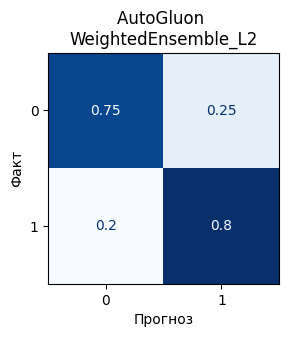

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap='Blues', colorbar=False, normalize='true')
ax.set_title('AutoGluon \n'+AG_best_model), ax.set_xlabel('Прогноз'), ax.set_ylabel('Факт')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       179
           1       0.74      0.80      0.77       163

    accuracy                           0.77       342
   macro avg       0.78      0.78      0.77       342
weighted avg       0.78      0.77      0.77       342



Итоговые оценки модели:

In [ ]:
f1   = f1_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
acc  = accuracy_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_pred)

print('F1-score  : {0:0.4f}'.format(f1))
print('Precision : {0:0.4f}'.format(prec))
print('Recall    : {0:0.4f}'.format(rec))
print('Accuracy  : {0:0.4f}'.format(acc))
print('AUC       : {0:0.4f}'.format(auc))

F1-score  : 0.7729
Precision : 0.7443
Recall    : 0.8037
Accuracy  : 0.7749
AUC       : 0.7761


Добавляем метрики модели в итоговую таблицу результатов:

In [ ]:
score_results.append(('AutoGluon', AG_best_model, f1, prec, rec, acc, auc, AG_best_model))

### 3️⃣ **h2o**

Устанавливаем библиотеку **h2o**:

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945085 sha256=1888ec9b9b2ece257aac0e202368fb21c6ad6278aeb7766cd19d1911033eacc3
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o


Загружаем модуль **h2o** из библиотеки и запускаем его:

In [ ]:
import h2o
h2o.init(ip="localhost", port=54321)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwqku1q_q
  JVM stdout: /tmp/tmpwqku1q_q/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwqku1q_q/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_unknownUser_ef9ys5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Загружаем набор данных из хранилища:

In [ ]:
blood = h2o.import_file('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/blood.csv')
blood.head(3)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Recency,Frequency,Monetary,Time,Class
2,50,12500,98,1
0,13,3250,28,1
1,16,4000,35,1


Разделяем данные на *обучающий* и *тестовый* наборы в соотношении **70/30**:

In [ ]:
train_data, valid_data = blood.split_frame(ratios=[.7], seed=1234)
train_data.shape, valid_data.shape

((534, 5), (214, 5))

Определяем рабочие признаки и целевую переменную модели:

In [ ]:
train_data['Class'] = train_data['Class'].asfactor()
predictors = train_data.columns[:-1]
response  = train_data.columns[-1]
print(predictors)
print(response)

['Recency', 'Frequency', 'Monetary', 'Time']
Class


Трансформируем столбцы целевых признаков в факторы. Фактор - это переменная, которая принимают ограниченное количество различных значений, т.е.  категориальная переменная.

Такую трансформацию необходимо сделать для того, чтобы библиотека h2o определяла задачу как классификацию. Если оставить тип столбцов числовым - h2o будет воспринимать проблему как задачу регрессии:

In [ ]:
train_data[response] = train_data[response].asfactor()
valid_data[response] = valid_data[response].asfactor()

В библиотеке *h2o* применяется собственный метод **model.train()** для тренировки модели, а не традиционный **model.fit()** как в библиотеке *Scikit-Learn*.

Установим ограничение в виде максимального количества моделей для прогнозирования *max_models*, а также параметр *balance_classes* для устранения дисбаланса данных и вызовем метод **H2OAutoML** автоматического машинного обучения модели:

In [ ]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=20, seed=1234)
aml.train(x=predictors, y=response, training_frame=train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230915_133557_model_1


Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 702 weights/biases, 12.5 KB, 982,560 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight            weight_rms           mean_bias               bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  --------------------  ----------  ---------------------  -------------------  ----------------------  -------------------
    1        4        Input             15.0
    2        100      RectifierDropout  50.0       0.0   0.0   0.007056518657045672  0.022532686591148376  0.0         0.0473171040251691     0.21523064374923706  0.10690977867944047     0.19968652725219727
    3        2        Softmax                      0.0   0.0   0.002277071802818682  0.003010156564414501  0.0         -0.011522027208120561  0.46509695053100586  -0.0036337051497550427  0.09885779023170471

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15174299976210084
RMSE: 0.3895420385043196
LogLoss: 0.4811123319328858
Mean Per-Class Error: 0.313359413202934
AUC: 0.7467090464547678
AUCPR: 0.5108422834230979
Gini: 0.49341809290953553

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2171742417391315
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      313  96   0.2347   (96.0/409.0)
1      49   76   0.392    (49.0/125.0)
Total  362  172  0.2715   (145.0/534.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217174     0.511785  146
max f2                       0.0812182    0.653409  272
max f0point5                 0.41791      0.563549  62
max accuracy                 0.448997     0.807116  55
max precision                0.701344     1         0
max recall                   0.0145303    1         364
max specificity              0.701344     1         0
max absolute_mcc             0.370673     0.390446  84
max min_per_class_accuracy   0.186927     0.672     179
max mean_per_class_accuracy  0.217174     0.686641  146
max tns                      0.701344     409       0
max fns                      0.701344     124       0
max fps                      9.57574e-07  409       378
max tps                      0.0145303    125       364
max tnr                      0.701344     1         0
max fnr                      0.701344     0.992     0
max fpr                      9.57574e-07  1         378
max tpr                      0.0145303    1         364

Gains/Lift Table: Avg response rate: 23.41 %, avg score: 19.36 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011236                    0.612876           2.848     2.848              0.666667         0.651134   0.666667                    0.651134            0.032           0.032                      184.8     184.8              0.02711
2        0.0205993                   0.56806            3.4176    3.10691            0.8              0.586762   0.727273                    0.621874            0.032           0.064                      241.76    210.691            0.056665
3        0.0299625                   0.539883           3.4176    3.20

Выведем список моделей по результатам обучения, список сортируется c метрикой **AUC** по умолчанию:

In [ ]:
h2o.automl.get_leaderboard(aml, extra_columns='algo')

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,algo
DeepLearning_grid_1_AutoML_1_20230915_133557_model_1,0.712401,0.504682,0.438037,0.331032,0.400269,0.160216,DeepLearning
DeepLearning_grid_3_AutoML_1_20230915_133557_model_1,0.702631,0.510515,0.383513,0.316929,0.409089,0.167354,DeepLearning
GLM_1_AutoML_1_20230915_133557,0.698738,0.502239,0.405378,0.321819,0.404664,0.163753,GLM
StackedEnsemble_BestOfFamily_1_AutoML_1_20230915_133557,0.698161,0.501393,0.422902,0.341027,0.402776,0.162229,StackedEnsemble
DeepLearning_grid_2_AutoML_1_20230915_133557_model_1,0.697633,0.510661,0.420638,0.347237,0.405309,0.164275,DeepLearning
StackedEnsemble_AllModels_1_AutoML_1_20230915_133557,0.696958,0.500874,0.426838,0.344127,0.402541,0.162039,StackedEnsemble
GBM_1_AutoML_1_20230915_133557,0.693633,0.502395,0.41729,0.345359,0.404621,0.163718,GBM
DeepLearning_1_AutoML_1_20230915_133557,0.689203,0.516081,0.43778,0.348792,0.403874,0.163114,DeepLearning
GBM_grid_1_AutoML_1_20230915_133557_model_2,0.683785,0.504297,0.411175,0.348577,0.404703,0.163784,GBM
XGBoost_grid_1_AutoML_1_20230915_133557_model_2,0.680176,0.508018,0.409664,0.345575,0.405969,0.164811,XGBoost


Лучшая модель по результатам обучения:

In [ ]:
aml.leader

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230915_133557_model_1


Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 702 weights/biases, 12.5 KB, 982,560 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight            weight_rms           mean_bias               bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  --------------------  ----------  ---------------------  -------------------  ----------------------  -------------------
    1        4        Input             15.0
    2        100      RectifierDropout  50.0       0.0   0.0   0.007056518657045672  0.022532686591148376  0.0         0.0473171040251691     0.21523064374923706  0.10690977867944047     0.19968652725219727
    3        2        Softmax                      0.0   0.0   0.002277071802818682  0.003010156564414501  0.0         -0.011522027208120561  0.46509695053100586  -0.0036337051497550427  0.09885779023170471

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15174299976210084
RMSE: 0.3895420385043196
LogLoss: 0.4811123319328858
Mean Per-Class Error: 0.313359413202934
AUC: 0.7467090464547678
AUCPR: 0.5108422834230979
Gini: 0.49341809290953553

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2171742417391315
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      313  96   0.2347   (96.0/409.0)
1      49   76   0.392    (49.0/125.0)
Total  362  172  0.2715   (145.0/534.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217174     0.511785  146
max f2                       0.0812182    0.653409  272
max f0point5                 0.41791      0.563549  62
max accuracy                 0.448997     0.807116  55
max precision                0.701344     1         0
max recall                   0.0145303    1         364
max specificity              0.701344     1         0
max absolute_mcc             0.370673     0.390446  84
max min_per_class_accuracy   0.186927     0.672     179
max mean_per_class_accuracy  0.217174     0.686641  146
max tns                      0.701344     409       0
max fns                      0.701344     124       0
max fps                      9.57574e-07  409       378
max tps                      0.0145303    125       364
max tnr                      0.701344     1         0
max fnr                      0.701344     0.992     0
max fpr                      9.57574e-07  1         378
max tpr                      0.0145303    1         364

Gains/Lift Table: Avg response rate: 23.41 %, avg score: 19.36 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011236                    0.612876           2.848     2.848              0.666667         0.651134   0.666667                    0.651134            0.032           0.032                      184.8     184.8              0.02711
2        0.0205993                   0.56806            3.4176    3.10691            0.8              0.586762   0.727273                    0.621874            0.032           0.064                      241.76    210.691            0.056665
3        0.0299625                   0.539883           3.4176    3.20

In [ ]:
aml.training_info

{'creation_epoch': '1694784958',
 'start_epoch': '1694784958',
 'start_XGBoost_def_2': '1694784958',
 'start_GLM_def_1': '1694784971',
 'start_GBM_def_5': '1694784974',
 'start_XGBoost_def_1': '1694784979',
 'start_DRF_def_1': '1694784985',
 'start_GBM_def_2': '1694784991',
 'start_GBM_def_3': '1694784995',
 'start_GBM_def_4': '1694784998',
 'start_XGBoost_def_3': '1694785001',
 'start_DRF_XRT': '1694785007',
 'start_GBM_def_1': '1694785012',
 'start_DeepLearning_def_1': '1694785014',
 'start_XGBoost_grid_1': '1694785019',
 'start_GBM_grid_1': '1694785037',
 'start_DeepLearning_grid_1': '1694785040',
 'start_DeepLearning_grid_2': '1694785137',
 'start_DeepLearning_grid_3': '1694785291',
 'start_StackedEnsemble_best_of_family_xglm': '1694785439',
 'start_StackedEnsemble_all_xglm': '1694785441',
 'stop_epoch': '1694785443',
 'duration_secs': '485'}

Проанализируем матрицу ошибок и другие характеристики модели на тестовых данных *valid_data*:

In [ ]:
predictions = aml.leader.predict(valid_data)
predictions

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.49039,0.50961
1,0.40077,0.59923
1,0.65268,0.34732
1,0.46622,0.53378
1,0.501318,0.498682
1,0.46622,0.53378
1,0.734007,0.265993
1,0.734007,0.265993
1,0.446504,0.553496
1,0.467084,0.532916


In [ ]:
perform = aml.leader.model_performance(valid_data)
perform

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.141083568083715
RMSE: 0.3756109264700842
LogLoss: 0.4268859847498637
Mean Per-Class Error: 0.22846595570139458
AUC: 0.8395054494316184
AUCPR: 0.5806695910747405
Gini: 0.6790108988632368

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1990937829489311
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      133  28   0.1739   (28.0/161.0)
1      15   38   0.283    (15.0/53.0)
Total  148  66   0.2009   (43.0/214.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.199094     0.638655  61
max f2                       0.11575      0.750751  94
max f0point5                 0.401797     0.66474   27
max accuracy                 0.401797     0.827103  27
max precision                0.401797     0.766667  27
max recall                   0.045675     1         129
max specificity              0.64393      0.993789  0
max absolute_mcc             0.199094     0.507577  61
max min_per_class_accuracy   0.186927     0.770186  71
max mean_per_class_accuracy  0.186927     0.771886  71
max tns                      0.64393      160       0
max fns                      0.64393      53        0
max fps                      1.42778e-06  161       166
max tps                      0.045675     53        129
max tnr                      0.64393      0.993789  0
max fnr                      0.64393      1         0
max fpr                      1.42778e-06  1         166
max tpr                      0.045675     1         129

Gains/Lift Table: Avg response rate: 24.77 %, avg score: 18.23 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0140187                   0.593946           2.69182   2.69182            0.666667         0.619501   0.666667                    0.619501            0.0377358       0.0377358                  169.182   169.182            0.0315247
2        0.0233645                   0.552048           0         1.61509            0                0.556038   0.4                         0.594116            0               0.0377358                  -100      61.5094            0.0191023
3        0.0327103                   0.545981           4.03774   2.30728            1                0.547926   0.571429                    0.580919            0.0377358       0.0754717                  303.774   130.728            0.0568382
4        0.0420561                   0.537516           2.01887   2.24319            0.5              0.541335   0.555556                    0.572122            0.0188679       0.0943396                  101.887   124.319            0.0694949
5        0.0560748                   0.53378            2.69182   2.35535            0.666667         0.534344   0.583333                    0.562678            0.0377358       0.132075                   169.182   135.535            0.10102
6        0.102804                    0.456842           3.63396   2.93654            0.9              0.502514   0.727273                    0.535331            0.169811        0.301887                   263.396   193.654            0.26462
7        0.149533                    0.370841           2.82642   2.90212            0.7              0.409909   0.71875                     0.496136            0.132075        0.433962                   182.642   190.212            0.378062
8        0.200935                    0.32714  

Итоговые оценки модели:

In [ ]:
f1   = perform.F1()[0][1]
prec = perform.precision()[0][1]
rec  = perform.recall()[0][1]
acc  = perform.accuracy()[0][1]
auc  = perform.auc()

print('F1-score  : {0:0.4f}'.format(f1))
print('Precision : {0:0.4f}'.format(prec))
print('Recall    : {0:0.4f}'.format(rec))
print('Accuracy  : {0:0.4f}'.format(acc))
print('AUC       : {0:0.4f}'.format(auc))

F1-score  : 0.6387
Precision : 0.7667
Recall    : 1.0000
Accuracy  : 0.8271
AUC       : 0.8395


Добавляем метрики модели в итоговую таблицу результатов:

In [ ]:
score_results.append(('H2O', aml.leader.key, f1, prec, rec, acc, auc, aml.leader))

### 4️⃣ **PyCaret**

Устанавливаем библиотеку **PyCaret**:

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from pycaret.utils.generic import enable_colab
enable_colab()

In [ ]:
import pycaret
print('Версия библиотеки:', pycaret.__version__)

Версия библиотеки: 3.1.0


Загружаем из библиотеки модуль для построения моделей классификации:

In [ ]:
import pycaret.classification
blood = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/blood.csv')

In [ ]:
from pycaret.classification import setup, create_model, compare_models, finalize_model, plot_model
from pycaret.classification import tune_model, ensemble_model, evaluate_model, predict_model, pull

Устанавливаем целевую переменную:

In [ ]:
target='Class'

Инициализируем среду выполнения (pipeline):

- игнорируем признак **Monetary** по результатам ранее проведённого EDA
- устанавливаем параметр **fix_imbalance** для устранения дисбаланса классов данных
- устанавливаем параметр **remove_outliers** для удаления выбросов
- выбираем соотношение обучающего/тестового набора **70/30**:

In [ ]:
pipeline = setup(
    data=blood,
    target=target,
    train_size=0.7,
    ignore_features=['Monetary'],
    fix_imbalance=True,
    remove_outliers=True,
    session_id=1234
)

,Description,Value
0,Session id,1234
1,Target,Class
2,Target type,Binary
3,Original data shape,"(748, 5)"
4,Transformed data shape,"(983, 4)"
5,Transformed train set shape,"(758, 4)"
6,Transformed test set shape,"(225, 4)"
7,Ignore features,1
8,Numeric features,3
9,Preprocess,True


Из таблицы выше мы видим, что среда выполнения в автоматическом режиме
- определила задачу как бинарную классификацию (строка 2)
- разделила набор данных на обучающую и тестовую выборки (строки 4, 5, 6)
- удалила 5% выбросов (строки 13, 14)
- провела балансировку набора данных методом **SMOTE** (строки 15, 16)
- разделила набор данных на 10 выборок методом **StratifiedKFold** для дальнейшего обучения и тренировки (строки 17, 18)

Сравним все доступные в библиотеке модели с ранжированием по параметру **F1**:

In [ ]:
PyCaret_best_model = compare_models(include=['catboost', 'gbc', 'xgboost', 'rf', 'dt', 'lightgbm', 'et'], sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7266,0.7360,0.5096,0.4370,0.4632,0.2842,0.2894,5.6560
gbc,Gradient Boosting Classifier,0.7112,0.7050,0.4750,0.4092,0.4332,0.2435,0.2477,1.3750
rf,Random Forest Classifier,0.7206,0.6906,0.4032,0.4227,0.4064,0.2263,0.2294,1.4450
lightgbm,Light Gradient Boosting Machine,0.7054,0.6934,0.4186,0.3990,0.4003,0.2089,0.2124,1.0340
et,Extra Trees Classifier,0.7015,0.6798,0.3936,0.3832,0.3796,0.1869,0.1905,1.1680
dt,Decision Tree Classifier,0.6880,0.5998,0.3615,0.3688,0.3456,0.1471,0.1552,0.5340
xgboost,Extreme Gradient Boosting,0.6881,0.6739,0.3385,0.3496,0.3365,0.1379,0.1393,0.6450


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
PyCaret_best_model_name = pull().Model[0]
print(PyCaret_best_model_name)

CatBoost Classifier


Создадим модель, используя лучший вариант из вышеприведённого списка:

In [ ]:
pbm = create_model(PyCaret_best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7170,0.7981,0.6154,0.4444,0.5161,0.3234,0.3320
1,0.7358,0.7096,0.2308,0.4286,0.3000,0.1549,0.1662
2,0.6981,0.6962,0.4615,0.4000,0.4286,0.2249,0.2259
3,0.7500,0.7375,0.5000,0.4615,0.4800,0.3158,0.3162
4,0.7500,0.7812,0.4167,0.4545,0.4348,0.2747,0.2751
5,0.6923,0.6885,0.5000,0.3750,0.4286,0.2239,0.2282
6,0.6731,0.6229,0.5833,0.3684,0.4516,0.2353,0.2479
7,0.7692,0.7854,0.6667,0.5000,0.5714,0.4179,0.4260
8,0.7692,0.7938,0.5833,0.5000,0.5385,0.3858,0.3879


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pbm_results = pull()
print('Метрика F1 новой модели: {0:0.4f}'.format(pbm_results.F1['Mean']))

Метрика F1 новой модели: 0.4632


Матрица ошибок новой модели с гиперпараметрами по умолчанию:

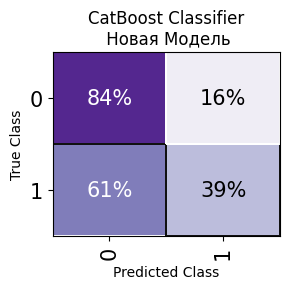

In [ ]:
figure, ax = plt.subplots(figsize=(3, 3))
plot_model(pbm, plot='confusion_matrix', plot_kwargs={'percent':True, 'title':PyCaret_best_model_name+'\n Новая Модель', 'cmap':'Purples', 'colorbar':False})

Проведём настройку гиперпараметров модели с оптимизацией по метрике **F1**, а также увеличим количество итераций с 10 (по умолчанию) до 30.

В **PyCaret** уже имеется встроенная сетка гиперпараметров для каждой из моделей библиотеки:

In [ ]:
tuned_pbm = tune_model(pbm, n_iter=30, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7170,0.7740,0.6154,0.4444,0.5161,0.3234,0.3320
1,0.6981,0.6288,0.3846,0.3846,0.3846,0.1846,0.1846
2,0.7547,0.7192,0.6923,0.5000,0.5806,0.4136,0.4246
3,0.7308,0.7438,0.5833,0.4375,0.5000,0.3209,0.3271
4,0.8077,0.8188,0.7500,0.5625,0.6429,0.5149,0.5249
5,0.7115,0.6990,0.5000,0.4000,0.4444,0.2529,0.2557
6,0.6923,0.7021,0.5833,0.3889,0.4667,0.2624,0.2731
7,0.7692,0.8042,0.7500,0.5000,0.6000,0.4468,0.4649
8,0.6923,0.7438,0.5833,0.3889,0.4667,0.2624,0.2731


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 30 candidates, totalling 300 fits


Отмечаем улучшение метрики '**F1**' после настройки гиперпараметров:

In [ ]:
tuned_pbm_results = pull()
print('Метрика F1 новой модели: {0:0.4f}'.format(pbm_results.F1['Mean']))
print('Метрика F1 после настройки гиперпараметров: {0:0.4f}'.format(tuned_pbm_results.F1['Mean']))

Метрика F1 новой модели: 0.4632
Метрика F1 после настройки гиперпараметров: 0.5131


Гиперпараметры модели по умолчанию и после оптимизации:

In [ ]:
pbm

In [ ]:
tuned_pbm

Матрица ошибок модели с настроенными гиперпараметрами:

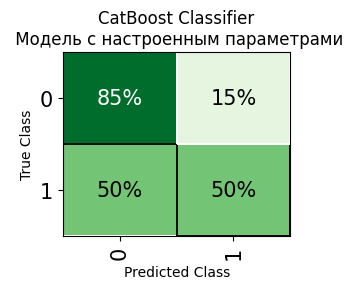

In [ ]:
figure, ax = plt.subplots(figsize=(3, 3))
plot_model(tuned_pbm, plot='confusion_matrix', plot_kwargs={'percent':True, 'title':PyCaret_best_model_name+'\n Модель с настроенным параметрами', 'cmap':'Greens', 'colorbar':False})

Для дальнейшего улучшения результатов прогнозирования создадим ансамбль из ранее настроенных моделей **tuned_pbm**:

In [ ]:
bagged_tuned_pbm = ensemble_model(tuned_pbm, optimize='F1', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6981,0.7779,0.6923,0.4286,0.5294,0.3248,0.3451
1,0.6792,0.6308,0.3077,0.3333,0.3200,0.1106,0.1107
2,0.7547,0.7115,0.6923,0.5000,0.5806,0.4136,0.4246
3,0.6923,0.7354,0.5833,0.3889,0.4667,0.2624,0.2731
4,0.8077,0.8208,0.6667,0.5714,0.6154,0.4882,0.4908
5,0.7115,0.7010,0.5000,0.4000,0.4444,0.2529,0.2557
6,0.7115,0.7042,0.5833,0.4118,0.4828,0.2909,0.2994
7,0.7885,0.8188,0.8333,0.5263,0.6452,0.5052,0.5323
8,0.6923,0.7521,0.5833,0.3889,0.4667,0.2624,0.2731


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [ ]:
bagged_tuned_pbm_results = pull()
print('Метрика F1 новой модели: {0:0.4f}'.format(pbm_results.F1['Mean']))
print('Метрика F1 после настройки гиперпараметров: {0:0.4f}'.format(tuned_pbm_results.F1['Mean']))
print('Метрика F1 после настройки гиперпараметров и создания ансамбля: {0:0.4f}'.format(bagged_tuned_pbm_results['F1']['Mean']))

Метрика F1 новой модели: 0.4632
Метрика F1 после настройки гиперпараметров: 0.5131
Метрика F1 после настройки гиперпараметров и создания ансамбля: 0.5051


Матрица ошибок модели с настроенными гиперпараметрами и ансамблем:

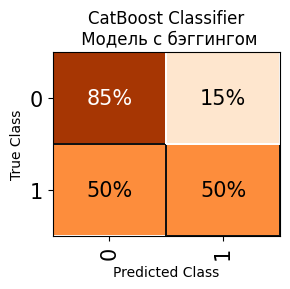

In [ ]:
figure, ax = plt.subplots(figsize=(3, 3))
plot_model(bagged_tuned_pbm, plot='confusion_matrix',
           plot_kwargs={'percent':True, 'title':PyCaret_best_model_name+'\n Модель с бэггингом', 'cmap':'Oranges', 'colorbar':False})

Отчёт классификации:

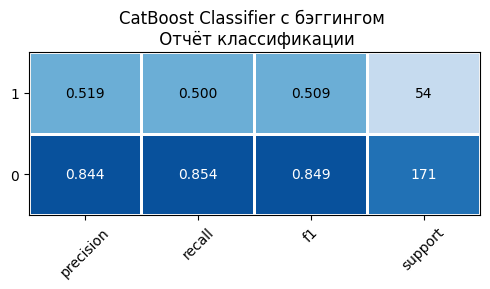

In [ ]:
plt.figure(figsize = (5, 3))
plot_model(bagged_tuned_pbm, plot='class_report',
           plot_kwargs={'percent':True, 'title':PyCaret_best_model_name+' с бэггингом \n Отчёт классификации', 'cmap':'Blues', 'colorbar':False})

Проанализируем различные метрики итоговой модели:

In [ ]:
evaluate_model(bagged_tuned_pbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Проведём оценку обученной модели на тестовых данных:

In [ ]:
predictions = predict_model(bagged_tuned_pbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7689,0.7137,0.5000,0.5192,0.5094,0.3583,0.3585


In [ ]:
final_model_results = pull()
final_model_name = final_model_results.Model[0]

Завершаем работу над моделью для последующего развёртывания:

In [ ]:
final_bagged_tuned_pbm = finalize_model(bagged_tuned_pbm)

Итоговые результаты работы модели:

In [ ]:
print('Метрика F1 новой модели: {0:0.4f}'.format(pbm_results.F1.Mean))
print('Метрика F1 после настройки гиперпараметров: {0:0.4f}'.format(tuned_pbm_results.F1.Mean))
print('Метрика F1 после настройки гиперпараметров и создания ансамбля: {0:0.4f}'.format(bagged_tuned_pbm_results.F1.Mean))
print('Метрика F1 на выборке с тестовыми данными: {0:0.4f}'.format(final_model_results.F1[0]))

Метрика F1 новой модели: 0.4632
Метрика F1 после настройки гиперпараметров: 0.5131
Метрика F1 после настройки гиперпараметров и создания ансамбля: 0.5051
Метрика F1 на выборке с тестовыми данными: 0.5094


In [ ]:
f1   = final_model_results.F1[0]
prec = final_model_results['Prec.'][0]
rec  = final_model_results.Recall[0]
acc  = final_model_results.Accuracy[0]
auc  = final_model_results.AUC[0]

print('F1-score  : {0:0.4f}'.format(f1))
print('Precision : {0:0.4f}'.format(prec))
print('Recall    : {0:0.4f}'.format(rec))
print('Accuracy  : {0:0.4f}'.format(acc))
print('AUC       : {0:0.4f}'.format(auc))

F1-score  : 0.5094
Precision : 0.5192
Recall    : 0.5000
Accuracy  : 0.7689
AUC       : 0.7137


Добавляем метрики модели в итоговую таблицу результатов:

In [ ]:
score_results.append(('PyCaret', PyCaret_best_model_name, f1, prec, rec, acc, auc, tuned_pbm))

## ✅ **Сравнение моделей**

Собранные ранее итоговые данные для сравнения моделей:

In [ ]:
for score in score_results:
  print(score)

('Scikit-Learn', 'RandomForestClassifier', 0.7272727272727272, 0.7453416149068323, 0.7100591715976331, 0.7329376854599406, 0.7330057762750071, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False))
('Scikit-Learn', 'GradientBoostingClassifier', 0.7371601208459215, 0.7530864197530864, 0.7218934911242604, 0.7418397626112759, 0.7418991265145112, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=30,
                           max_features='log2', max_leaf

### Метод **cross_val_score**

Одним из способов сравнения моделей прогнозирования в библиотеке **Scikit-Learn** является метод **cross_val_score** c использованием кросс-валидации:

In [ ]:
models = []

models.append((score_results[0][0]+'\n'+score_results[0][1], score_results[0][7]))
models.append((score_results[1][0]+'\n'+score_results[1][1], score_results[1][7]))
models.append((score_results[4][0]+'\n'+score_results[4][1], score_results[4][7]))

Scikit-Learn
RandomForestClassifier: 0.755768 (0.041420)
Scikit-Learn
GradientBoostingClassifier: 0.754883 (0.034244)
PyCaret
CatBoost Classifier: 0.710327 (0.028076)


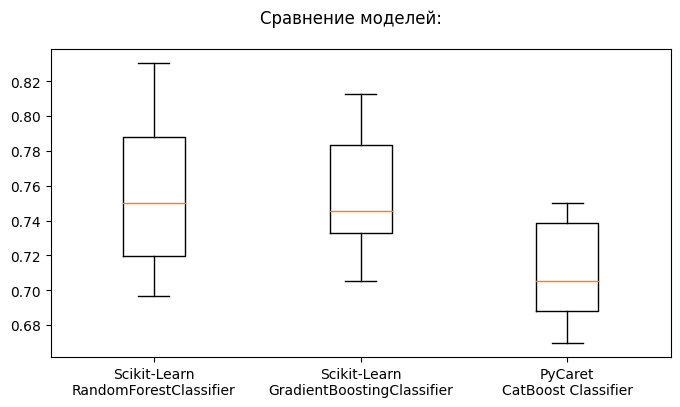

In [ ]:
from sklearn import model_selection

results = []
names = []
scoring = 'accuracy'
seed = 1234

for name, model in models:
  kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
  model_result = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
  names.append(name)
  results.append(model_result)
  msg = "%s: %f (%f)" % (name, model_result.mean(), model_result.std())
  print(msg)

fig = plt.figure(figsize=(8, 4))
fig.suptitle('Сравнение моделей:')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

К сожалению, вследствие того, что модели прогнозирования и наборы данных (DataFrame) в библиотеках **AutoGluon** и **h2o** имеют различную структуру и форматы - не представляется возможным провести итоговую оценку всех ранее использованных методов библиотек вышеобозначенным способом, а также в графическом виде через характиристики **ROC/AUC** (Receiver Operating Characteristic).

Поэтому далее будем проводить числовую оценку с использованием метрики **F1-score** как одной из основных оценок качества прогнозирования.

### Метрика **F1-score**

Переведём итоговые данные в формат **pd.DataFrame** и отсортируем их по убыванию метрики **F1-score**:

In [ ]:
column_names = ['Библиотека', 'Модель', 'F1-score', 'Precision', 'Recall', 'Accuracy', 'AUC', 'Parameters']
final_scores = pd.DataFrame(data=score_results, columns=column_names).sort_values(by='F1-score', ascending=False)
final_scores = final_scores.drop(['Parameters'], axis=1)
final_scores.style.hide_index().format(precision=4, thousands=".", decimal=",")

Библиотека,Модель,F1-score,Precision,Recall,Accuracy,AUC
AutoGluon,WeightedEnsemble_L2,"0,7729","0,7443","0,8037","0,7749","0,7761"
Scikit-Learn,GradientBoostingClassifier,"0,7372","0,7531","0,7219","0,7418","0,7419"
Scikit-Learn,RandomForestClassifier,"0,7273","0,7453","0,7101","0,7329","0,7330"
H2O,DeepLearning_grid_1_AutoML_1_20230915_133557_model_1,"0,6387","0,7667","1,0000","0,8271","0,8395"
PyCaret,CatBoost Classifier,"0,5094","0,5192","0,5000","0,7689","0,7137"


Выберем из таблицы модель с максимальным показателем **F1-score**. Это и будет лучшая модель по результатам сравнения:

In [ ]:
best_of_best = final_scores.loc[final_scores['F1-score'].idxmax()]
print('Лучший результат показала модель', best_of_best.Модель, 'из библиотеки', best_of_best.Библиотека)
print('F1-score  : {0:0.4f}'.format(best_of_best['F1-score']))
print('Precision : {0:0.4f}'.format(best_of_best.Precision))
print('Recall    : {0:0.4f}'.format(best_of_best.Recall))
print('Accuracy  : {0:0.4f}'.format(best_of_best.Accuracy))
print('AUC       : {0:0.4f}'.format(best_of_best.AUC))

Лучший результат показала модель WeightedEnsemble_L2 из библиотеки AutoGluon
F1-score  : 0.7729
Precision : 0.7443
Recall    : 0.8037
Accuracy  : 0.7749
AUC       : 0.7761


## ✅ **Выводы по результаты анализа**

В данном исследовании рассматривалась задача бинарной классификации по ранее выбранному набору данных донорства крови. Согласно условиям, необходимо было определить - будет ли донор сдавать кровь в определенный момент времени.

Выбор лучшей модели производился по числовой метрике **F1** как одной из основных характеристик при решении задач бинарной классификации.

В процессе исследования был проведен предварительный анализ данных (**EDA**), а также созданы и протестированы модели машинного обучения в следующих библитеках:

1.   **Scikit-Learn**
     - Random Forest Classifier
     - Gradient Boosting Classifier
          
2.   **AutoGluon**
     - предиктор Tabular Predictor с ансамблем моделей

3.   **h2o**
     - модель автоматического машинного обучения H2OAutoML

4.   **PyCaret**
     - выбиралась лучшая модель по метрике F1 из списка

При построении всех моделей было осуществлено раздельное прогнозирование как на обучающих, так и на тестовых (новых) данных, а также проводилась обработка данных для устранения дисбаланса классов.

Для моделей *Random Forest Classifier* и *Gradient Boosting Classifier* из Scikit-Learn была проведена предварительная настройка различных гиперпараметров.

В библиотеке *AutoGluon* выполнялся автоматический анализ набора данных, целевой переменной, а также предварительная ускоренная оценка модели. Библиотека самостоятельно, в автоматическом режиме - построила ансамбль из всех использованных при обучении предиктора моделей, а затем использовала его для прогнозирования.

В библиотеке *PyCaret* была выполнена предварительная настройка различных гиперпараметров, затем проведён бэггинг модели, а потом создан ансамбль моделей.

Лучшие характеристики по результатам сравнения были продемонстрированы моделью

In [ ]:
print(best_of_best.Модель, 'из библиотеки', best_of_best.Библиотека)

WeightedEnsemble_L2 из библиотеки AutoGluon


Таблица итоговых результатов:

In [ ]:
final_scores.sort_values(by='F1-score', ascending=False)
final_scores.style.hide_index().format(precision=4, thousands=".", decimal=",")

Библиотека,Модель,F1-score,Precision,Recall,Accuracy,AUC
AutoGluon,WeightedEnsemble_L2,"0,7729","0,7443","0,8037","0,7749","0,7761"
Scikit-Learn,GradientBoostingClassifier,"0,7372","0,7531","0,7219","0,7418","0,7419"
Scikit-Learn,RandomForestClassifier,"0,7273","0,7453","0,7101","0,7329","0,7330"
H2O,DeepLearning_grid_1_AutoML_1_20230915_133557_model_1,"0,6387","0,7667","1,0000","0,8271","0,8395"
PyCaret,CatBoost Classifier,"0,5094","0,5192","0,5000","0,7689","0,7137"


Как видно из итоговой таблицы модели библиотек **h2o** и **PyCaret** существенно уступают по характеристикам моделям из **AutoGluon** и **Scikit-Learn**.

Возможно это связано с малым количеством признаков в наборе данных или издержками внутренней автоматизации процессов. Необходимо провести дополнительный анализ и оценку рабочих процессов в этих библиотеках.